In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
!gdown --id 1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
!gdown --id 1bs8PHTExPfItW636-HVRVYwjjPilQVgy

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
To: /content/id_map.parquet
100% 1.20M/1.20M [00:00<00:00, 5.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
To: /content/train.csv
42.9MB [00:01, 25.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bs8PHTExPfItW636-HVRVYwjjPilQVgy
To: /content/test.csv
24.8MB [00:01, 22.2MB/s]


In [2]:
!pip install imbalanced-learn
!pip install scikit-learn==0.24
!pip install catboost
!pip install tldextract

     |████████████████████████████████| 22.3 MB 232 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 67.4 MB 43 kB/s 
     |████████████████████████████████| 87 kB 4.7 MB/s 



# Dependencies

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


import time
from tqdm import tqdm_notebook

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier

import re
from wordcloud import WordCloud
from tldextract import extract
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

In [4]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

from imblearn.pipeline import Pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE

# Support

In [5]:
def merge_data_and_domain(data, id_map):
    for i in range(1,11):
        data = pd.merge(data, id_map.rename(columns={"id":"webpage"+str(i), "domain":"domain"+str(i)}).loc[:, ["webpage"+str(i), "domain"+str(i)]], on="webpage"+str(i), how="left")

    string = data.loc[:, ["session_id"]+["domain"+str(i) for i in range(1,11)]].fillna("left")
    string["string"] = string.apply(lambda x: " ".join(x.values[1:]), axis=1)
    string.loc[:, "preproc_tokens"] = string.loc[:, "string"].apply(lambda x: x.split(' ')).values
    return string
    
def merge_data_and_suf(data, id_map):
    for i in range(1,11):
        data = pd.merge(data, id_map.rename(columns={"id":"webpage"+str(i), "suf":"suf"+str(i)}).loc[:, ["webpage"+str(i), "suf"+str(i)]], on="webpage"+str(i), how="left")

    string = data.loc[:, ["session_id"]+["suf"+str(i) for i in range(1,11)]].fillna("no_data").replace("", "empty")
    return string

In [6]:
def time_features_extraction(data):
    time_data  = data.loc[:, ["time"+str(i) for i in range(1,11)]]

    for column in time_data.columns:
        time_data[column] = pd.to_datetime(time_data[column])

    time_data = time_data.assign(
            # number of missing pages (from 10 max)
            nans_count=lambda x: x.isna().sum(axis=1),
            # avg hour of day in a session
            avg_hour=lambda x: np.round(x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1)),
            # avg day of week in a session
            avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1)
        )

    for i in range(1,10):
        time_data["delta"+str(i)] = (time_data["time" + str(i+1)] - time_data["time" + str(i)]).dt.seconds
    
    time_data.drop(columns=[f'time{i+1}' for i in range(10)], inplace=True)

    time_data.fillna(0, inplace=True)

    return time_data

In [7]:
def train_word2vec(train_domain_features, test_domain_features, 
                   size, window, min_count, workers, sg, refit):
    # Store the model in following file
    word2vec_model_file = OUTPUT_FOLDER + '/word2vec_' + str(size) + '.model'
    # Store the vectors for train data in following file
    word2vec_filename = OUTPUT_FOLDER + '/train_review_word2vec.csv'
    if refit:
        start_time = time.time()
        preproc_tokens = pd.Series(train_domain_features['preproc_tokens']).values
        # Train the Word2Vec Model
        w2v_model = Word2Vec(preproc_tokens, min_count=min_count, size=size, workers=workers, window=window, sg=sg)
        # save model to file
        w2v_model.save(word2vec_model_file)

        # save emb to file
        with open(word2vec_filename, 'w+') as word2vec_file:
            for index, row in train_domain_features.iterrows():
                model_vector = (np.mean([w2v_model[token] for token in row['preproc_tokens']], axis=0)).tolist()
                if index == 0:
                    header = ",".join(str(x) for x in range(size))
                    word2vec_file.write(header)
                    word2vec_file.write("\n")
                # Check if the line exists else it is vector of zeros
                if type(model_vector) is list:  
                    line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
                else:
                    line1 = ",".join([str(0) for i in range(size)])
                word2vec_file.write(line1)
                word2vec_file.write('\n')
    else:
        # Load model
        w2v_model = Word2Vec.load(word2vec_model_file)

    # Load train from the filename
    word2vec_train = pd.read_csv(word2vec_filename)

    test_features_word2vec = np.array([x for x in range(size)])
    test_ = np.array([0 for x in range(size)])
    for index, row in test_domain_features.iterrows():
        model_vector = np.mean([w2v_model[token] for token in row['preproc_tokens'] if token in w2v_model.wv.vocab], axis=0)
        if type(model_vector) is np.ndarray:
            test_ = np.vstack([test_, model_vector])
            if test_.shape[0] > 500:
                test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])
                test_ = np.array([0 for x in range(size)])
        else:
            test_ = np.vstack([test_, np.array([0 for i in range(size)])])
            if test_.shape[0] > 500:
                test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])
                test_ = np.array([0 for x in range(size)])
    test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])

    word2vec_test = pd.DataFrame(test_features_word2vec[1:])

    return word2vec_train, word2vec_test

In [8]:
def func_roc_auc(proba, y):
    sns.set(style="whitegrid", palette='Dark2')
    
    auc = roc_auc_score(np.array(y), np.transpose(proba)[1])
    print(f'Лучшее качество auc_best_estimator: {auc:.3}')
    
    fpr, tpr, _ = roc_curve(y, proba[:,1])
    
    f = plt.figure()
    plt.plot(fpr, tpr, label = 'best_estimator')
    plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")
    plt.show()

In [9]:
def save_submission(pred):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/data/notebook_submission.csv')

In [10]:
def text_preprocessing_1(text):
    # split text by . or -
    clean_text = re.split("\.|-", text)
    # join text
    clean_text = " ".join(clean_text)
    # remove nums
    clean_text = re.sub("[0-9]", "", clean_text)
    # remove spaces
    clean_text = re.sub(' +', ' ', clean_text)
    # split
    clean_text = re.split(" ", clean_text)
    # seq must be longer then 1
    clean_text = [x for x in clean_text if len(x)>1]
    # join text
    clean_text = " ".join(clean_text)

    return clean_text

In [11]:
def unique_features(domain_features):
    n_unique = domain_features.assign(
        nans_count=lambda x: x.isna().sum(axis=1),
        # number of unique pages in session
        n_unique_pages=lambda x: x.filter(like='domain').apply(lambda row: row.nunique(), axis=1) / (10 - x.nans_count)).loc[:, ["session_id", "n_unique_pages"]]

    return n_unique

In [12]:
def text_preprocessing_2(text, vocab):
    clean_text =  text.split(" ")
    clean_text = [x for x in clean_text if x in vocab]
    clean_text =  " ".join(clean_text)
    return clean_text

In [ ]:
def best_size_search(vector_size, window_size=2):
    word2vec_train, word2vec_test = train_word2vec(train_domain_features, test_domain_features, sg=1,
                                                   size=vector_size, window=window_size, min_count=1, workers=3, refit=True)
    
    train_set = pd.concat([train_suf, n_unique_train, word2vec_train, time_train], axis=1)
    train_set.set_index("session_id", inplace=True)
    test_set = pd.concat([test_suf, n_unique_test, word2vec_test, time_test], axis=1)
    test_set.set_index("session_id", inplace=True)

    test_set.columns = range(test_set.shape[1])
    train_set.columns = range(train_set.shape[1])

    model = CatBoostClassifier(task_type="GPU", metric_period=10, random_state=42,
                            learning_rate=0.02, depth=10, l2_leaf_reg=3, iterations=200, 
                            auto_class_weights = "Balanced", loss_function = "Logloss",
                            logging_level="Silent")
    model.fit(train_set, y_train)

    # probas train
    probas = model.predict_proba(train_set.to_numpy())
    auc_train = roc_auc_score(y_train.to_numpy(), np.transpose(probas)[1])
    # probas test
    probas = model.predict_proba(test_set.to_numpy())
    auc_test = roc_auc_score(y_test.to_numpy(), np.transpose(probas)[1])
    # print auc
    print(f'auc_train: {auc_train:.8}, auc_test: {auc_test:.8}')

In [13]:
# id_map.loc[:, "preproc_text"] = [text_preprocessing_1(text = x) for x in id_map["webpage"].values]

# Preprocessing

In [13]:
OUTPUT_FOLDER = "/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/model_train"

* top_level domen
* Кластеризация сайтов  
---
* Длительность сессии

In [14]:
data = pd.read_csv("./train.csv")
id_map = pd.read_parquet("/content/id_map.parquet")

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=(["target"])), 
                                                    data.loc[:, ["target"]],  
                                                    test_size=0.2, 
                                                    shuffle=False, 
                                                    random_state=42)

In [16]:
train = pd.merge(x_train, y_train, how="left", left_index=True, right_index=True)

In [17]:
# get user's webpages 
user_frame = train.loc[train["target"]==1].reset_index(drop=True)

array = np.array([])
for element in ["webpage"+str(x) for x in range(1,11)]:
    unique_array = user_frame.loc[:, element].unique()
    array = np.concatenate([array, unique_array])
array = {x for x in array if x==x}

id_map["target"] = 0
id_map.loc[id_map["id"].isin(array), "target"] = 1

In [18]:
# extract "sub-domain", "domain", "suf" from url of webpage
list_ = [list(extract(id_map.loc[i].webpage)) for i in id_map.index]
id_map.loc[:, ["sub","domain","suf"]] = list_

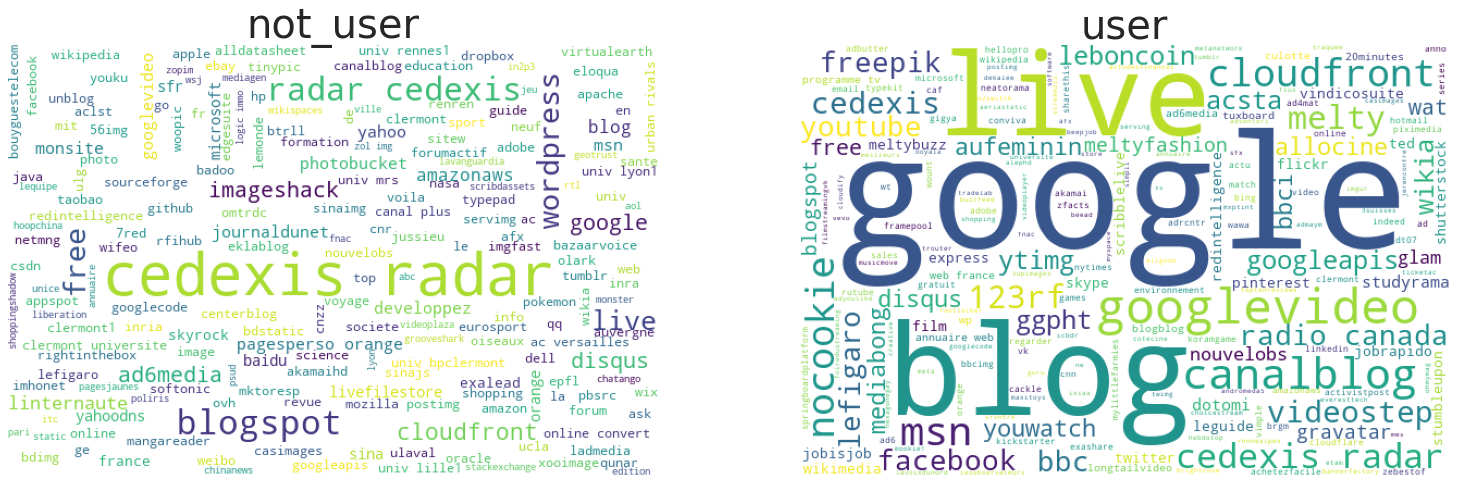

In [19]:
# word cloud for user's and other's domains
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(id_map.loc[id_map["target"]==0, "domain"].values))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('not_user', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(id_map.loc[id_map["target"]==1, "domain"].values))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('user', fontsize=40);
plt.show()

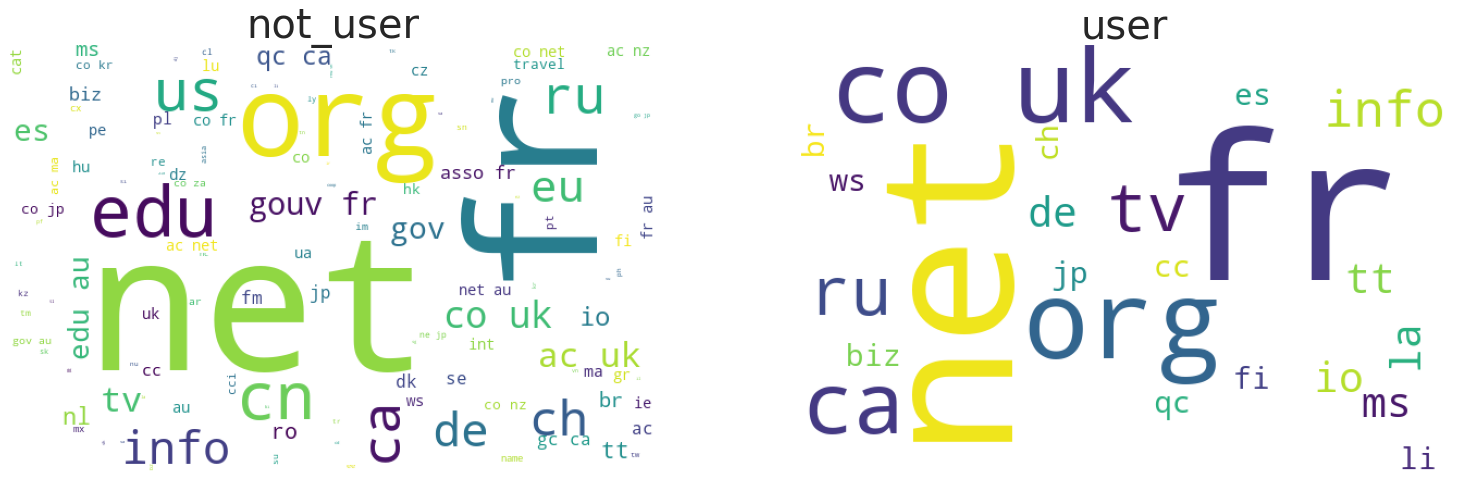

In [20]:
# word cloud for user's and other's suf 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(id_map.loc[id_map["target"]==0, "suf"].values))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('not_user', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(id_map.loc[id_map["target"]==1, "suf"].values))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('user', fontsize=40);
plt.show()

In [21]:
%%time
train_suf = merge_data_and_suf(x_train, id_map)
test_suf = merge_data_and_suf(x_test, id_map)

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

train_suf["sequence"] = train_suf.iloc[:, 1:].apply(lambda x: " ".join(x.values), axis=1)
test_suf["sequence"] = test_suf.iloc[:, 1:].apply(lambda x: " ".join(x.values), axis=1)

# vectirize input train data (simple BOW)
train_counts = count_vect.fit_transform(train_suf["sequence"])
test_counts = count_vect.transform(test_suf["sequence"])

# tf-idf
train_tfidf_suf = tfidf_transformer.fit_transform(train_counts)
train_suf = pd.DataFrame(train_tfidf_suf.toarray())
test_tfidf_suf = tfidf_transformer.transform(test_counts)
test_suf = pd.DataFrame(test_tfidf_suf.toarray())

CPU times: user 4.23 s, sys: 133 ms, total: 4.37 s
Wall time: 4.35 s


In [22]:
id_map.loc[:, "domain"] = [text_preprocessing_1(text=x) for x in id_map.loc[:, "domain"].values]
id_map.loc[:, "sub"] = [text_preprocessing_1(text=x) for x in id_map.loc[:, "sub"].values]
id_map.loc[:, "domain"] = id_map.loc[:, ["sub", "domain"]].apply(lambda x: " ".join(x.values), axis=1)

In [23]:
%%time
time_train = time_features_extraction(x_train)
time_train["sum"] = time_train.iloc[:, 3:].sum(axis=1)
time_test = time_features_extraction(x_test)
time_test["sum"] = time_test.iloc[:, 3:].sum(axis=1)
time_test.reset_index(inplace=True, drop=True)

CPU times: user 870 ms, sys: 23.8 ms, total: 894 ms
Wall time: 890 ms


In [24]:
%%time
train_domain_features = merge_data_and_domain(x_train, id_map)
test_domain_features = merge_data_and_domain(x_test, id_map)

CPU times: user 3.46 s, sys: 178 ms, total: 3.64 s
Wall time: 3.62 s


In [25]:
%%time
n_unique_train = unique_features(train_domain_features)
n_unique_test = unique_features(test_domain_features)

CPU times: user 10.9 s, sys: 270 ms, total: 11.2 s
Wall time: 10.9 s


In [ ]:
# vector_sizes = [100, 500, 1000]
# for vector_size in vector_sizes:
#     best_size_search(vector_size=vector_size, window_size=2)

auc_train: 0.99886735, auc_test: 0.98964172
auc_train: 0.99900699, auc_test: 0.98976469
auc_train: 0.99903507, auc_test: 0.98847617


In [26]:
word2vec_train, word2vec_test = train_word2vec(train_domain_features, test_domain_features, sg=1,
                                                size=500, window=3, min_count=1, workers=3, refit=True)

train_set = pd.concat([train_suf, n_unique_train, word2vec_train, time_train], axis=1)
train_set.set_index("session_id", inplace=True)
test_set = pd.concat([test_suf, n_unique_test, word2vec_test, time_test], axis=1)
test_set.set_index("session_id", inplace=True)

test_set.columns = range(test_set.shape[1])
train_set.columns = range(train_set.shape[1])

In [27]:
model = CatBoostClassifier(task_type="GPU", metric_period=10, 
                           auto_class_weights = "Balanced", 
                           loss_function = "Logloss")

grid = {'learning_rate' : [0.03, 0.01],
        'depth'         : [10, 15],
        'l2_leaf_reg'   : [3, 6],
        "iterations"    : [200, 250]}

In [ ]:
grid_search_result = model.grid_search(grid, 
                                       X=train_set, 
                                       y=y_train, 
                                       shuffle=False,
                                       cv=3)

In [ ]:
grid_search_result["params"]

Лучшее качество auc_best_estimator: 0.997


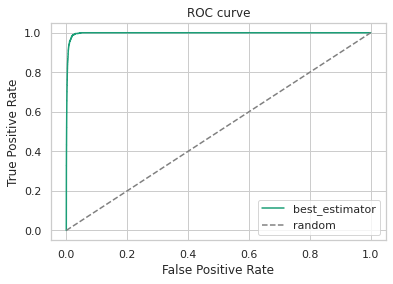

In [ ]:
probas = model.predict_proba(train_set.to_numpy())
func_roc_auc(proba=probas, y=y_train.to_numpy())

Лучшее качество auc_best_estimator: 0.988


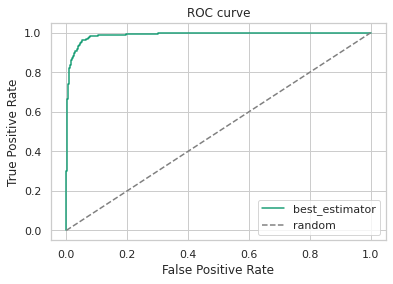

In [ ]:
probas = model.predict_proba(test_set.to_numpy())
func_roc_auc(proba=probas, y=y_test.to_numpy())

In [ ]:
from gensim.models.fasttext import FastText
fastText_model = FastText(corpus, size=100, workers=4)

In [ ]:
# bow
count_vect = CountVectorizer()

# vectirize input train data (simple BOW)
id_map_counts = count_vect.fit_transform(id_map.preproc_text)
id_map_counts = id_map_counts.T

data = pd.DataFrame(index=count_vect.get_feature_names(), data=np.sum(id_map_counts, axis=1), columns=["counts"])
data.sort_values(by="counts", ascending=False, inplace=True)
vocabulary = data.loc[data["counts"] > 2].reset_index()

id_map.loc[:, "preproc_text_2"] = [text_preprocessing_2(text=x, vocab=vocabulary["index"].values) for x in id_map["preproc_text"].values]


In [ ]:
# sm = SMOTE(random_state=42, k_neighbors=7, sampling_strategy=0.20)
# train_resampled, y_train_resampled = sm.fit_resample(train_set, y_train)